# Informe de Análisis: Uso de Dispositivos Inteligentes
**Fecha:** Julio 2025  
**Autor:** Julián Salto


## Objetivos
- Identificar tendencias en el uso de dispositivos inteligentes (pasos, calorías, sueño, ritmo cardíaco).  
- Aplicar estos hallazgos para mejorar la experiencia de las usuarias de Bellabeat.  
- Proponer estrategias de marketing basadas en datos.



## Metodología
1. **Ask**: Analizar bien qué problema se busca resolver
2. **Preparación de datos**: Lectura de CSV con pandas  
3. **Limpieza**: Verificación de duplicados y consistencia de tablas.  
4. **Análisis exploratorio**: Cálculo de estadísticas por usuaria 
5. **Visualización**: Generación de gráficos para ilustrar patrones.


#### ASK

What is the problem you are trying to solve?
How can your insights drive business decisions?

A lo largo del informe y analisis, se va a intentar llegar al objetivo mencionado anteriormente, analizando 
las relaciones entre las distintas variables, el comportamiento de las mujeres a lo largo del dia, sus 
habitos y salud, de forma tal de poder observar ciertos patrones en esos comportamientos para luego usarlos
para el bien de la empresa. De esta forma, se va a poder mejorar la estrategia de la compañía, con el fin de 
que el cliente se sienta cómodo con el producto ofrecido.

#### PREPARE

In [1]:

import pandas as pd
import duckdb
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

# Carga de datos
daily_act = pd.read_csv("C:/Users/Julia/OneDrive/Escritorio/Data Science - Google/Capitulo 8/PROYECTO FINAL/Datos/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv")
sleep_day = pd.read_csv("C:/Users/Julia/OneDrive/Escritorio/Data Science - Google/Capitulo 8/PROYECTO FINAL/Datos/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv")
hourly_steps = pd.read_csv("C:/Users/Julia/OneDrive/Escritorio/Data Science - Google/Capitulo 8/PROYECTO FINAL/Datos/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/hourlySteps_merged.csv")
hourly_calories = pd.read_csv("C:/Users/Julia/OneDrive/Escritorio/Data Science - Google/Capitulo 8/PROYECTO FINAL/Datos/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/hourlyCalories_merged.csv")
heartrate = pd.read_csv("C:/Users/Julia/OneDrive/Escritorio/Data Science - Google/Capitulo 8/PROYECTO FINAL/Datos/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/heartrate_seconds_merged.csv")


Los conjuntos de datos vienen dados en formato csv. Uso pandas para transformarlos en data frames.
Solo importo los datos necesarios para este analisis.
Ademas son open-source data, por lo que no hay problema para su manipulacion y analisis.

#### PROCESS

-Analizo los conjuntos de datos utilizados para asegurar su integridad.

-Realizo cambios de formato de algunos datos para mantener la constancia entre los distintos df para luego trabajar con ellos

-Me aseguro que no hayan valores repetidos-duplicados

-Verifico que las tablas respeten todas las formas normales

In [2]:
# Formateo de fechas y extracción de horas
hourly_calories["ActivityHour"] = pd.to_datetime(
    hourly_calories["ActivityHour"],
    format="%m/%d/%Y %I:%M:%S %p"
)
hourly_steps["ActivityHour"] = pd.to_datetime(
    hourly_steps["ActivityHour"],
    format="%m/%d/%Y %I:%M:%S %p"
)

print(hourly_calories["ActivityHour"].dtype) 
print(hourly_steps["ActivityHour"].dtype)     

hourly_steps["ActivityHour"] = pd.to_datetime(hourly_steps["ActivityHour"])
hourly_steps["hora"] = hourly_steps["ActivityHour"].dt.time
heartrate["Time"] = pd.to_datetime(heartrate["Time"])
heartrate["hora"] = heartrate["Time"].dt.time
heartrate['hora'] = heartrate['hora'].astype(str)
heartrate['hora_solo'] = heartrate['hora'].str[:2]

# Vistazo rápido a los datos
daily_act.head(), sleep_day.head(), hourly_steps.head(), hourly_calories.head(), heartrate.head()


datetime64[ns]
datetime64[ns]


(           Id ActivityDate  TotalSteps  TotalDistance  TrackerDistance  \
 0  1503960366    4/12/2016       13162           8.50             8.50   
 1  1503960366    4/13/2016       10735           6.97             6.97   
 2  1503960366    4/14/2016       10460           6.74             6.74   
 3  1503960366    4/15/2016        9762           6.28             6.28   
 4  1503960366    4/16/2016       12669           8.16             8.16   
 
    LoggedActivitiesDistance  VeryActiveDistance  ModeratelyActiveDistance  \
 0                       0.0                1.88                      0.55   
 1                       0.0                1.57                      0.69   
 2                       0.0                2.44                      0.40   
 3                       0.0                2.14                      1.26   
 4                       0.0                2.71                      0.41   
 
    LightActiveDistance  SedentaryActiveDistance  VeryActiveMinutes  \
 0     

#### ANALYZE

A continuacion hago nuevos df que van a ser utiles para un posterior analisis y para realizar graficos

In [3]:
#
c = duckdb.query(""" 
SELECT hourly_calories.Id, hourly_calories.ActivityHour, hourly_steps.StepTotal, hourly_calories.Calories
FROM hourly_calories
INNER JOIN hourly_steps
ON hourly_calories.ActivityHour = hourly_steps.ActivityHour AND hourly_calories.Id = hourly_steps.Id
""") 
df0 = c.df()
#

#
c1 = duckdb.query(""" 
SELECT Id,AVG(TotalSteps) AS AvgSteps, AVG(totalDistance) AS AvgDist, AVG(Calories) AS AvgCal
FROM daily_act
GROUP BY Id
ORDER BY AvgSteps 
""") 
df = c1.df()

'''
Me defino un parametro para clasificar a las personas segun sus pasos diarios:
-sedentarismo: <5000 pasos
-moderado: 5000-10000 pasos
-activo: >10000 pasos
'''

def pasos(id):
    for i,fila in df.iterrows():
        if fila["Id"] == id:
            if fila["AvgSteps"] < 5000:
                return "Sedentario"
            elif fila["AvgSteps"] >= 5000 and fila["AvgSteps"] <= 10000:
                return "Moderado"
            
            return "Activo"
    
df["Tipo"] = df['Id'].apply(pasos)
#    

#
c2 = duckdb.query(""" 
SELECT Id,AVG(TotalMinutesAsleep) AS AvgSleep, AVG(TotalTimeInBed) AS AvgTimeBed
FROM sleep_day
GROUP BY Id
ORDER BY AvgSleep
""") 
df2 = c2.df()

'''
Me defino un parametro para clasificar a las personas segun sus horas de sueño diarias:
-insuficiente: <6 horas
-moderado: 6-8 horas
-mucha siesta: >8 horas (yo)
'''

def horas(id):
    for i,fila in df2.iterrows():
        if fila["Id"] == id:
            if fila["AvgSleep"] < 360:
                return "Insuficiente"
            elif fila["AvgSleep"] >= 360 and fila["AvgSleep"] <= 480:
                return "Ok"
            
            return "Demasiado"
    
df2["HorasSueño"] = df2['Id'].apply(horas)
#

#
c1 = duckdb.query(""" 
SELECT df.Id,df.AvgSteps, df2.AvgSleep
FROM df
INNER JOIN df2
ON df.Id = df2.Id
""") 
df3 = c1.df()
#

#
c1 = duckdb.query(""" 
SELECT Id,count(Id) as conteo
FROM daily_act
GROUP BY Id
""") 
df4 = c1.df()
#

#
c1 = duckdb.query(""" 
SELECT hora, avg(StepTotal) AS AvgStep
FROM hourly_steps
GROUP BY hora
ORDER BY hora
""") 
df5 = c1.df()
#

#
c1 = duckdb.query(""" 
SELECT hora_solo, avg(value) AS AvgValue
FROM heartrate
GROUP BY hora_solo
ORDER BY hora_solo
""") 
df6 = c1.df()
#

# Vistazo rápido a los datos
df0.head(), df.head(), df2.head(), df3.head(), df4.head(), df5.head(), df6.head()

(           Id        ActivityHour  StepTotal  Calories
 0  1503960366 2016-04-12 00:00:00        373        81
 1  1503960366 2016-04-12 01:00:00        160        61
 2  1503960366 2016-04-12 02:00:00        151        59
 3  1503960366 2016-04-12 03:00:00          0        47
 4  1503960366 2016-04-12 04:00:00          0        48,
            Id     AvgSteps   AvgDist       AvgCal        Tipo
 0  1927972279   916.129032  0.634516  2172.806452  Sedentario
 1  8792009665  1853.724138  1.186552  1962.310345  Sedentario
 2  4020332650  2267.225806  1.626129  2385.806452  Sedentario
 3  6775888955  2519.692308  1.813462  2131.769231  Sedentario
 4  1844505072  2580.064516  1.706129  1573.483871  Sedentario,
            Id    AvgSleep  AvgTimeBed    HorasSueño
 0  2320127002   61.000000   69.000000  Insuficiente
 1  7007744171   68.500000   71.500000  Insuficiente
 2  4558609924  127.600000  140.000000  Insuficiente
 3  3977333714  293.642857  461.142857  Insuficiente
 4  1644430081  294

#### SHARE

###### GRAFICOS Y ANALISIS

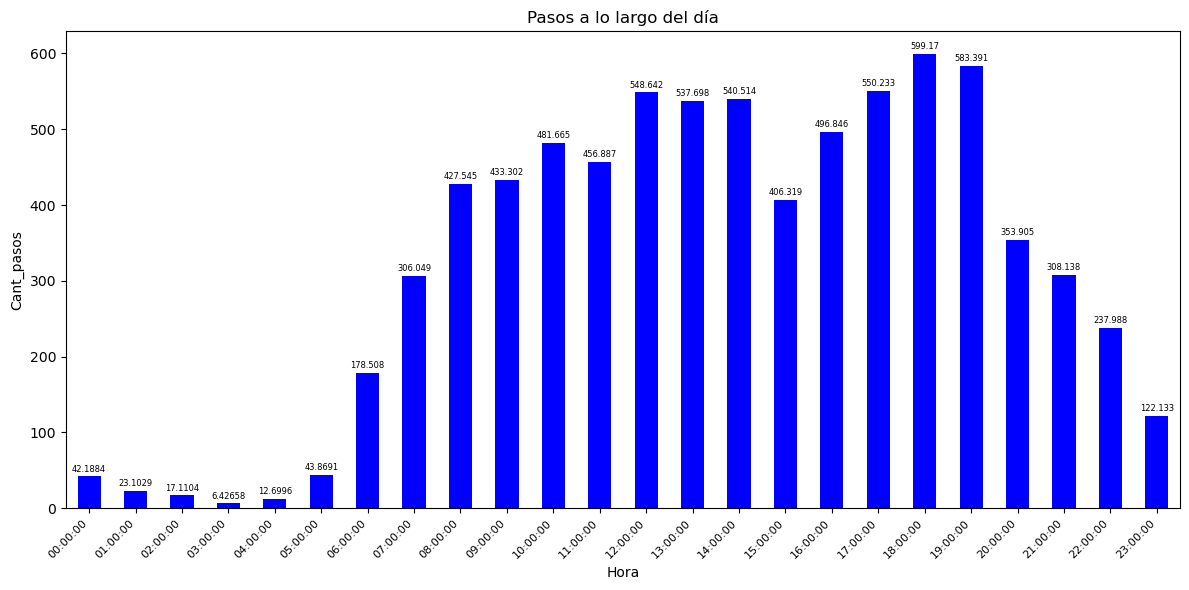

In [4]:
## 1
# Grafico con esas tablas.
fig, ax = plt.subplots(figsize=(12,6))
plt.rcParams['font.family'] = 'sans-serif'

df5.plot.bar(x = 'hora',
                       y = 'AvgStep',
                       ax = ax,
                       color = 'b',
                       legend = False)

# Ajustes.
ax.set_title('Pasos a lo largo del día')
ax.set_xlabel('Hora', fontsize='medium')
ax.set_ylabel('Cant_pasos', fontsize='medium')
#ax.set_ylim(0, 550)

# Coloco los valores arriba de cada barra.
ax.bar_label(ax.containers[0], fontsize=6, padding=2)

# Roto etiquetas en 'x' para que los nombres de las provincias queden claros.
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

Se pueden observar los pasos en promedio que hacen las mujeres a lo largo del día, siendo
entre las 8 y las 19 hs los horarios mas habituales.

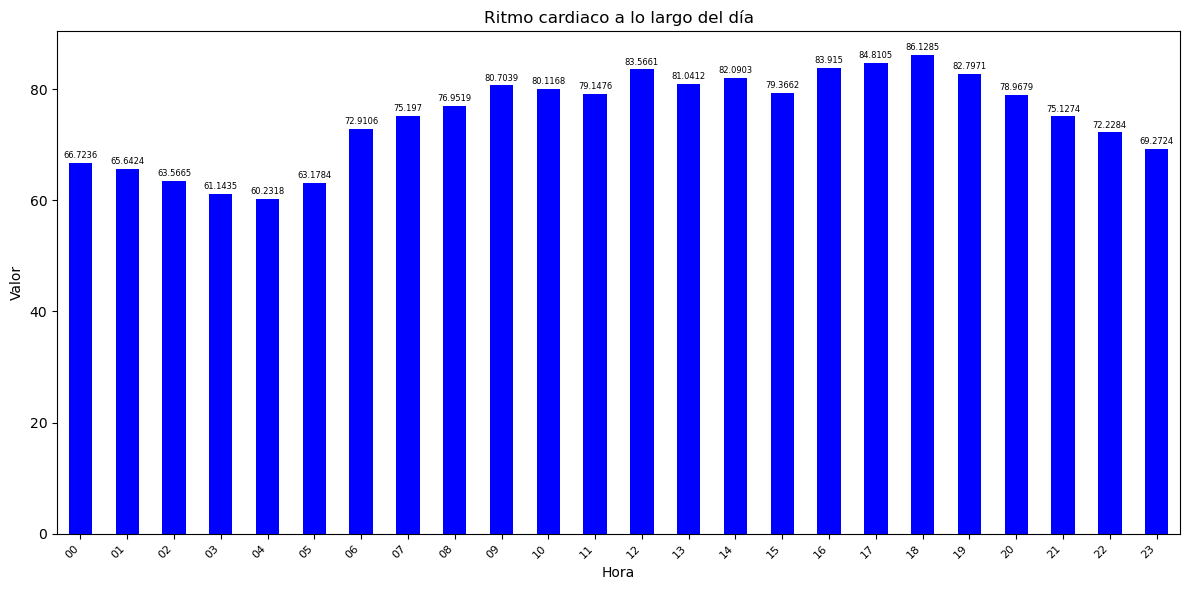

In [5]:
## 1b
# Grafico con esas tablas.
fig, ax = plt.subplots(figsize=(12,6))
plt.rcParams['font.family'] = 'sans-serif'

df6.plot.bar(x = 'hora_solo',
                       y = 'AvgValue',
                       ax = ax,
                       color = 'b',
                       legend = False)

# Ajustes.
ax.set_title('Ritmo cardiaco a lo largo del día')
ax.set_xlabel('Hora', fontsize='medium')
ax.set_ylabel('Valor', fontsize='medium')
#ax.set_ylim(0, 550)

# Coloco los valores arriba de cada barra.
ax.bar_label(ax.containers[0], fontsize=6, padding=2)

# Roto etiquetas en 'x' para que los nombres de las provincias queden claros.
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

Se observa la evolución del ritmo cardíaco de las mujeres a lo largo del día. Se puede ver que está directamente relacionado con los pasos.

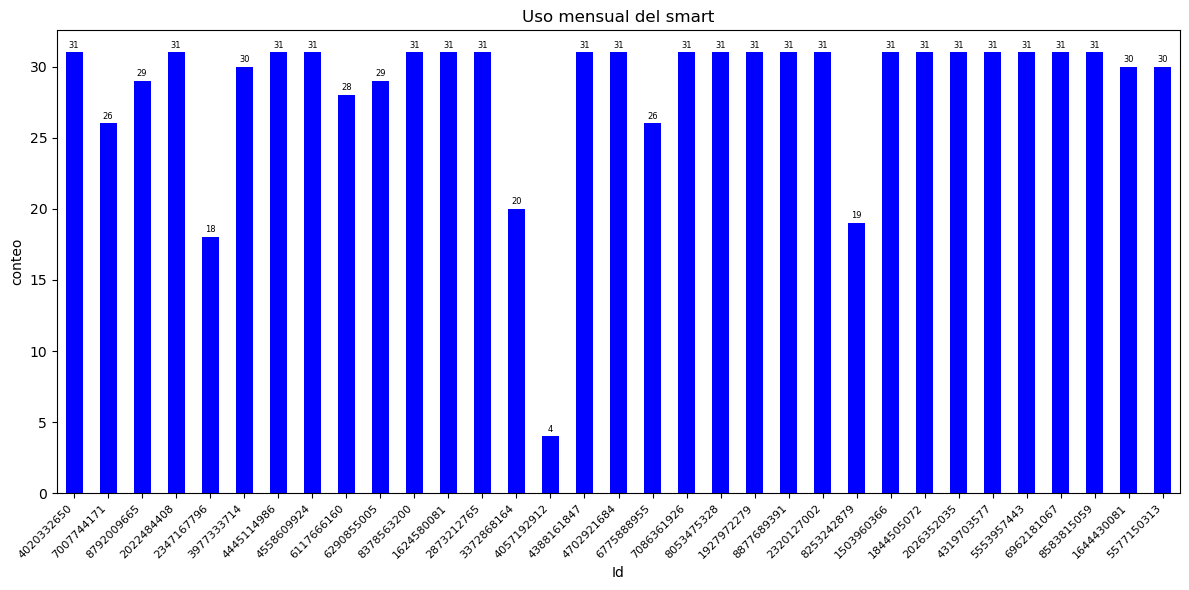

In [6]:
## 2

# Grafico con esas tablas.
fig, ax = plt.subplots(figsize=(12,6))
plt.rcParams['font.family'] = 'sans-serif'

df4.plot.bar(x = 'Id',
                       y = 'conteo',
                       ax = ax,
                       color = 'b',
                       legend = False)

# Ajustes.
ax.set_title('Uso mensual del smart')
ax.set_xlabel('Id', fontsize='medium')
ax.set_ylabel('conteo', fontsize='medium')
#ax.set_ylim(0, 550)

# Coloco los valores arriba de cada barra.
ax.bar_label(ax.containers[0], fontsize=6, padding=2)

# Roto etiquetas en 'x' para que los nombres de las provincias queden claros.
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

Muestra el uso mensual del smart de cada persona. De esto se ve que hay informacion insuficiente
ya que, hay personas que solo lo usan 20 o menos veces al mes, por lo que los datos estan incompletos

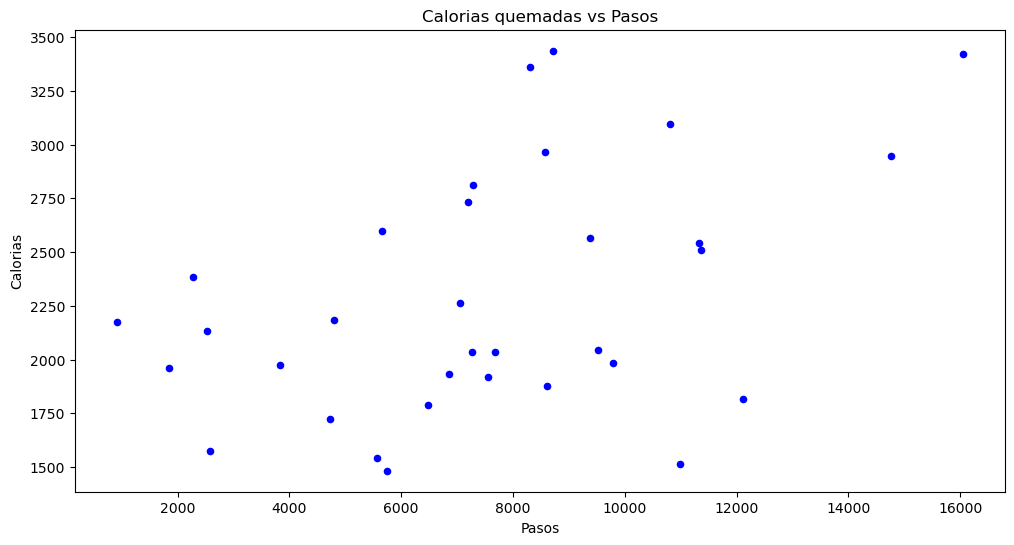

In [7]:
## 3

fig, ax = plt.subplots(figsize = (12,6))
plt.rcParams['font.family'] = 'sans-serif'

df.plot.scatter(x = 'AvgSteps',
                     y = 'AvgCal',
                     ax = ax,
                     color = 'b',
                     legend = False)

#ax.set_xscale('log')   # Aplico escala logarítmica para mayor separación entre los puntos -> Gráfico más comprensible.

# Ajustes.
ax.set_title('Calorias quemadas vs Pasos')
ax.set_xlabel('Pasos', fontsize = 'medium')
ax.set_ylabel('Calorias', fontsize = 'medium')
#ax.set_ylim(0, 400) 
plt.show() 

Muestra las calorias quemadas segun la cantidad de pasos. Se observa una leve relacion lineal
entre ambas variables, una nube un poco disperssa pero con cierta tendencia, lo cual es logico 
(a +pasos, +calorias quemadas)

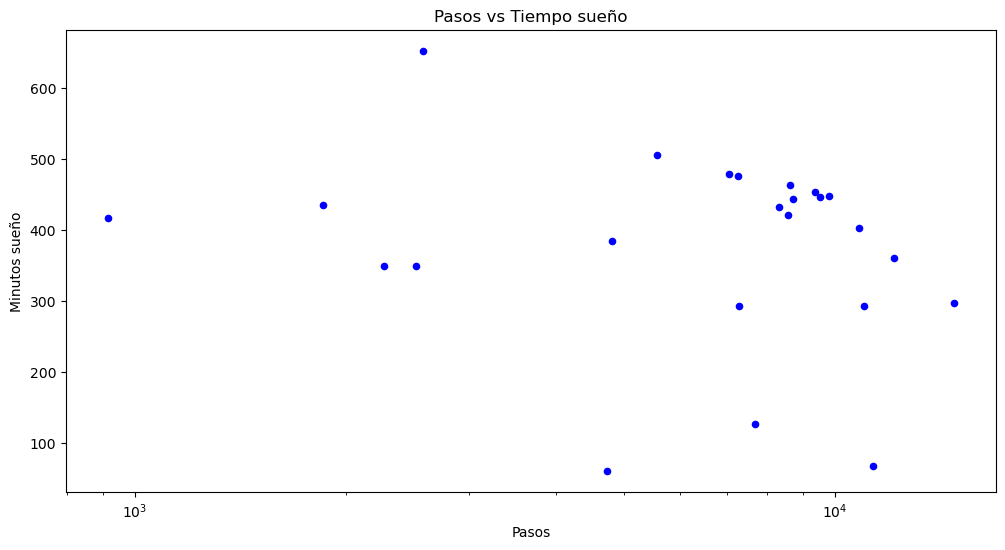

In [8]:
## 4

fig, ax = plt.subplots(figsize = (12,6))
plt.rcParams['font.family'] = 'sans-serif'

df3.plot.scatter(x = 'AvgSteps',
                     y = 'AvgSleep',
                     ax = ax,
                     color = 'b',
                     legend = False)

ax.set_xscale('log')   # Aplico escala logarítmica para mayor separación entre los puntos -> Gráfico más comprensible.

# Ajustes.
ax.set_title('Pasos vs Tiempo sueño')
ax.set_xlabel('Pasos', fontsize = 'medium')
ax.set_ylabel('Minutos sueño', fontsize = 'medium')
#ax.set_ylim(0, 400) 
plt.show() 

Muestra la cantidad de pasos en relacion a las horas de sueño de cada persona.
No se observa una relacion entre ambas variables. Los puntos estan muy dispersos

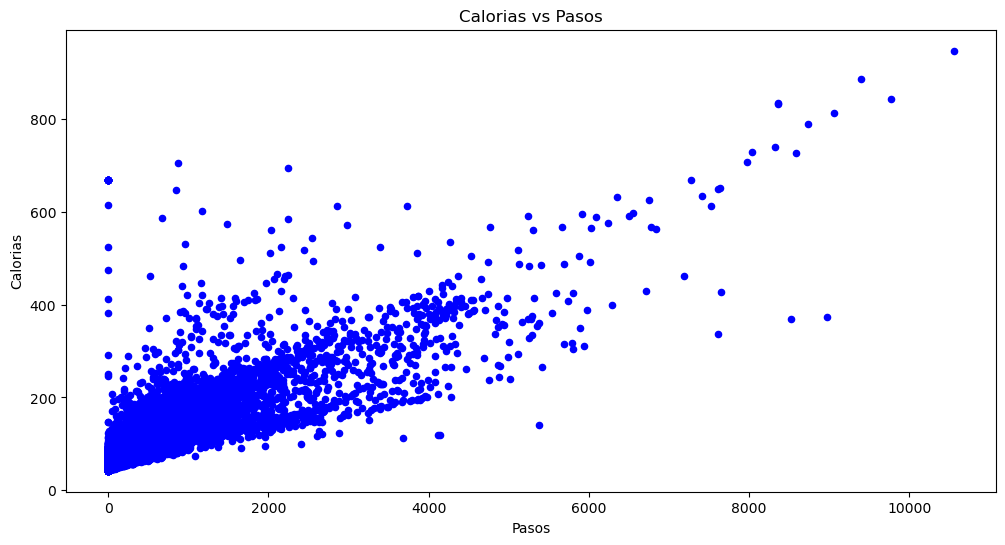

In [9]:
## 5

fig, ax = plt.subplots(figsize = (12,6))
plt.rcParams['font.family'] = 'sans-serif'

df0.plot.scatter(x = 'StepTotal',
                     y = 'Calories',
                     ax = ax,
                     color = 'b',
                     legend = False)


# Ajustes.
ax.set_title('Calorias vs Pasos')
ax.set_xlabel('Pasos', fontsize = 'medium')
ax.set_ylabel('Calorias', fontsize = 'medium')
#ax.set_ylim(0, 400) 
plt.show() 

Muestra las calorias quemadas segun la cantidad de pasos. Cada punto identifica a un usuario en una determinada hora del dia. 
Se observa una relacion lineal entre ambas variables, una nube un poco dispersa pero con una tendencia, lo cual es logico 
(a +pasos, +calorias quemadas)

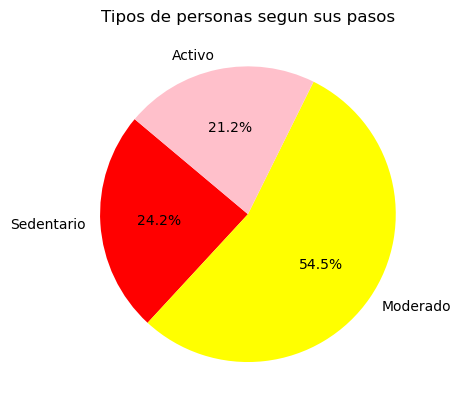

In [10]:
## 6

def cont(p):
    contador = 0
    for i,fila in df.iterrows():
        if fila["Tipo"] == p:
            contador += 1
    return contador

# Data to plot
labels = ['Sedentario', 'Moderado', 'Activo']
sizes = [cont("Sedentario"), cont("Moderado"), cont("Activo")]  # Percentages
colors = ['red', 'yellow', 'pink']
explode = (0, 0, 0)  # if you want to Highlight the first slice (Apples)

# Create the pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Tipos de personas segun sus pasos')

# Display the chart
plt.show()

El grafico muestra el tipo de mujeres que existen según los pasos que hacen de forma diaria.
Se puede observar que la gran mayoria realiza entre 5000 y 10000 pasos diarios, mientras que el 24% 
realiza menos de 5000 pasos y el 21% mas de 10000 conformando el grupo de personas activas.

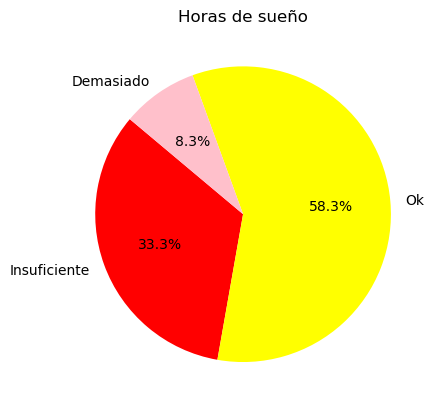

In [11]:
## 7

def cont2(p):
    contador = 0
    for i,fila in df2.iterrows():
        if fila["HorasSueño"] == p:
            contador += 1
    return contador

# Data to plot
labels = ['Insuficiente', 'Ok', 'Demasiado']
sizes = [cont2("Insuficiente"), cont2("Ok"), cont2("Demasiado")]  # Percentages
colors = ['red', 'yellow', 'pink']
explode = (0, 0, 0)  # if you want to Highlight the first slice (Apples)

# Create the pie chart
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Horas de sueño')

# Display the chart
plt.show()


El grafico muestra el tipo de mujeres que existen según las horas de sueño diarias.
Se puede observar que la gran mayoria duerme entre 6 y 8 hs diarias, mientras que el 33% 
duerme de forma insuficiente (menos de 6 hs) y solo el 8% duerme mas de 8 hs.
A partir de este grafico se identifica la gran cantidad de mujeres que duermen menos de lo recomendado.

### CONCLUSIONES

Cerrando el análisis del informe, se pudo obtener suficiente informacion para identificar ciertos patrones
que nos brindan datos valiosos a la hora de tomar decisiones sobre el uso de los smart.
Entre ellos, se obtuvo informacion sobre los pasos diarios de las personas, los horarios mas habituales, las horas
de sueño, calorias quemadas, ritmo cardíaco, y las relaciones entre todas esas variables.
Sin embargo, no todas las personas identificadas en los datos, usan el smart de forma diaria, por lo que
habian datos faltantes, lo cual afecta a la hora de sacar conclusiones.

A partir del analisis llevado a cabo, se podrian usar los patrones observados para implementar mejoras en las
estrategias de Bellabeat. Por ejemplo, se podrian buscar formas para incentivar a las personas a usar el samrt
durante los horarios de 7 - 21, ya que, es el rango horario donde mas informacion se puede recolectar sobre 
los usuarios. Por otro lado, si se quieren obtener mas datos sobre las horas de sueño, se podria hacer lo mismo
pero para horarios nocturnos.
Tambien, a partir de los ultimos 2 graficos, se puede tomar la decision de enviar notificaciones
a los usuarios que tengan pocas horas de sueño o baja cantidad de pasos realizados de forma
diaria, para así mejorar sus habitos. Esto se podria hacer con frases motivadoras en 
horarios pico de esas actividades, o tambien nombrando los beneficios que traen esos habitos.
A su vez, durante los horarios pico de sueño de cada usuario, se pueden establecer modos de
"no molestar", con el fin de llegar a un sueño profundo y sin distracciones.

Se pueden concentrar los anuncios en los horarios pico de uso de las apps.

Se puede establecer un sistema de retos y recompensas, donde a medida que los usuarios vayan
completando las metas diarias, se les regale ciertas recompensas relacionadas con la marca
(por ej descuentos de sus productos, regalos, frases alentadoras, vouchers, etc), 
de modo que se reduzca el abandono por parte de los usuarios hacia la empresa, y que ademas
aumente la venta y el uso de sus productos.

Por ultimo, para mejorar el uso del producto, se podria ademas, agregar funciones utiles como
la medicion de la hidratacion, la nutricion, menstruacion, entre otras cosas, priorizando la salud de los 
usuarios.